# Nerfies Dataset Processing.

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook contains an example workflow for converting a video file to a Nerfies dataset.

### Instructions

1. Convert a video into our dataset format using this notebook.
2. Train a Nerfie using the [training notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb).


### Notes
* While this will work for small datasets in a Colab runtime, larger datasets will require more compute power.
* If you would like to train a model on a serious dataset, you should consider copying this to your own workstation and running it there. Some minor modifications will be required, and you will have to install the dependencies separately.
* Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).

If you find this work useful, please consider citing:
```bibtex
@article{park2021nerfies
  author    = {Park, Keunhong 
               and Sinha, Utkarsh 
               and Barron, Jonathan T. 
               and Bouaziz, Sofien 
               and Goldman, Dan B 
               and Seitz, Steven M. 
               and Martin-Brualla, Ricardo},
  title     = {Nerfies: Deformable Neural Radiance Fields},
  journal   = {ICCV},
  year      = {2021},
}
```

## Install dependencies.

In [2]:
!apt-get install colmap ffmpeg

!pip install numpy
!pip install mediapipe 
!pip install tensorflow_graphics
!pip install git+https://github.com/google/nerfies.git@v2
!pip install "git+https://github.com/google/nerfies.git#egg=pycolmap&subdirectory=third_party/pycolmap"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  libamd2 libcamd2 libccolamd2 libceres1 libcholmod3 libcolamd2 libcxsparse3
  libfreeimage3 libgflags2.2 libglew2.1 libgoogle-glog0v5 libjxr0 libmetis5
  libraw19 libspqr2 libsuitesparseconfig5
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  colmap libamd2 libcamd2 libccolamd2 libceres1 libcholmod3 libcolamd2
  libcxsparse3 libfreeimage3 libgflags2.2 libglew2.1 libgoogle-glog0v5 libjxr0
  libmetis5 libraw19 libspqr2 libsuitesparseconfig5
0 upgraded, 17 newly installed, 0 to remove and 23 not upgraded.
Need to get 5,135 kB of archives.
After this operation, 20.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libsuitesparseconfig5 amd64 1:5.7.1+dfsg-2 [9,736 B]
Get:2 http://archive.ubuntu.com/ubuntu 

## Configuration.

Mount Google Drive onto `/content/gdrive`. You can skip this if you want to run this locally.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# @title Configure dataset directories
from pathlib import Path

# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = '/content/gdrive/MyDrive/nerfies_1/captures'  # @param {type: 'string'}
# @markdown The name of this capture. The working directory will be `$save_dir/$capture_name`. **Make sure you change this** when processing a new video.
capture_name = 'capture1'  # @param {type: 'string'}
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb'
rgb_raw_dir = root_dir / 'rgb-raw'
# Where to save the COLMAP outputs.
colmap_dir = root_dir / 'colmap'
colmap_db_path = colmap_dir / 'database.db'
colmap_out_path = colmap_dir / 'sparse'

colmap_out_path.mkdir(exist_ok=True, parents=True)
rgb_raw_dir.mkdir(exist_ok=True, parents=True)

print(f"""Directories configured:
  root_dir = {root_dir}
  rgb_raw_dir = {rgb_raw_dir}
  rgb_dir = {rgb_dir}
  colmap_dir = {colmap_dir}
""")

Directories configured:
  root_dir = /content/gdrive/MyDrive/nerfies_1/captures/capture1
  rgb_raw_dir = /content/gdrive/MyDrive/nerfies_1/captures/capture1/rgb-raw
  rgb_dir = /content/gdrive/MyDrive/nerfies_1/captures/capture1/rgb
  colmap_dir = /content/gdrive/MyDrive/nerfies_1/captures/capture1/colmap



In [ ]:
colmap_dir

PosixPath('/content/gdrive/MyDrive/nerfies_1/captures/capture1/colmap')

In [ ]:
type(colmap_out_path)

pathlib.PosixPath

## Dataset Processing.

### Load Video.

In this step we upload a video file and flatten it into PNG files using ffmpeg.

In [ ]:
# @title Upload video file.
# @markdown Select a video file (.mp4, .mov, etc.) from your disk. This will upload it to the local Colab working directory.
from google.colab import files

uploaded = files.upload()

Saving 20230224_114141.mp4 to 20230224_114141.mp4


In [ ]:
rgb_dir

PosixPath('/content/gdrive/MyDrive/nerfies_1/captures/capture1/rgb')

In [ ]:
# @title Flatten into images.

import cv2


# @markdown Flattens the video into images. The results will be saved to `rgb_raw_dir`.
video_path = next(iter(uploaded.keys()))

# @markdown Adjust `max_scale` to something smaller for faster processing.
max_scale = 1.0  # @param {type:'number'}
# @markdown A smaller FPS will be much faster for bundle adjustment, but at the expensive of a lower sampling density for training. For the paper we used ~15 fps but we default to something lower here to get you started faster.
# @markdown If given an fps of -1 we will try to auto-compute it.
fps = -1  # @param {type:'number'}
target_num_frames = 100 # @param {type: 'number'}

cap = cv2.VideoCapture(video_path)
input_fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if num_frames < target_num_frames:
  raise RuntimeError(
      'The video is too short and has fewer frames than the target.')

if fps == -1:
  fps = int(target_num_frames / num_frames * input_fps)
  print(f"Auto-computed FPS = {fps}")

# @markdown Check this if you want to reprocess the frames.
overwrite = True  # @param {type:'boolean'}

if (rgb_dir / '1x').exists() and not overwrite:
  raise RuntimeError(
      f'The R GB frames have already been processed. Check `overwrite` and run again if you really meant to do this.')
else:
  filters = f"mpdecimate,setpts=N/FRAME_RATE/TB,scale=iw*{max_scale}:ih*{max_scale}"
  tmp_rgb_raw_dir = 'rgb-raw'
  out_pattern = str('rgb-raw/%06d.png')
  !mkdir -p "$tmp_rgb_raw_dir"
  !ffmpeg -i "$video_path" -r $fps -vf $filters "$out_pattern"
  !mkdir -p "$rgb_raw_dir"
  !rsync -av "$tmp_rgb_raw_dir/" "$rgb_raw_dir/"

Auto-computed FPS = 8
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

In [ ]:
a = [1, 2, 3]
print(a[:2])

[1, 2]


In [ ]:
# @title Resize images into different scales.
# @markdown Here we save the input images at various resolutions (downsample by a factor of 1, 2, 4, 8). We use area relation interpolation to prevent moire artifacts.
import concurrent.futures
import numpy as np
import cv2
import imageio
from PIL import Image


def save_image(path, image: np.ndarray) -> None:
  print(f'Saving {path}')
  if not path.parent.exists():
    path.parent.mkdir(exist_ok=True, parents=True)
  with path.open('wb') as f:
    image = Image.fromarray(np.asarray(image))
    image.save(f, format=path.suffix.lstrip('.'))


def image_to_uint8(image: np.ndarray) -> np.ndarray:
  """Convert the image to a uint8 array."""
  if image.dtype == np.uint8:
    return image
  if not issubclass(image.dtype.type, np.floating):
    raise ValueError(
        f'Input image should be a floating type but is of type {image.dtype!r}')
  return (image * 255).clip(0.0, 255).astype(np.uint8)


def make_divisible(image: np.ndarray, divisor: int) -> np.ndarray:
  """Trim the image if not divisible by the divisor."""
  height, width = image.shape[:2]
  if height % divisor == 0 and width % divisor == 0:
    return image

  new_height = height - height % divisor
  new_width = width - width % divisor

  return image[:new_height, :new_width]


def downsample_image(image: np.ndarray, scale: int) -> np.ndarray:
  """Downsamples the image by an integer factor to prevent artifacts."""
  if scale == 1:
    return image

  height, width = image.shape[:2]
  if height % scale > 0 or width % scale > 0:
    raise ValueError(f'Image shape ({height},{width}) must be divisible by the'
                     f' scale ({scale}).')
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  return resized



image_scales = "1,2,4,8"  # @param {type: "string"}
image_scales = [int(x) for x in image_scales.split(',')]

tmp_rgb_dir = Path('rgb')

for image_path in Path(tmp_rgb_raw_dir).glob('*.png'):
  image = make_divisible(imageio.imread(image_path), max(image_scales))
  for scale in image_scales:
    save_image(
        tmp_rgb_dir / f'{scale}x/{image_path.stem}.png',
        image_to_uint8(downsample_image(image, scale)))

!rsync -av "$tmp_rgb_dir/" "$rgb_dir/"

Saving rgb/1x/000055.png


<ipython-input-11-9a55fa8754f8>:62: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = make_divisible(imageio.imread(image_path), max(image_scales))


Saving rgb/2x/000055.png
Saving rgb/4x/000055.png
Saving rgb/8x/000055.png
Saving rgb/1x/000076.png
Saving rgb/2x/000076.png
Saving rgb/4x/000076.png
Saving rgb/8x/000076.png
Saving rgb/1x/000036.png
Saving rgb/2x/000036.png
Saving rgb/4x/000036.png
Saving rgb/8x/000036.png
Saving rgb/1x/000073.png
Saving rgb/2x/000073.png
Saving rgb/4x/000073.png
Saving rgb/8x/000073.png
Saving rgb/1x/000066.png
Saving rgb/2x/000066.png
Saving rgb/4x/000066.png
Saving rgb/8x/000066.png
Saving rgb/1x/000002.png
Saving rgb/2x/000002.png
Saving rgb/4x/000002.png
Saving rgb/8x/000002.png
Saving rgb/1x/000007.png
Saving rgb/2x/000007.png
Saving rgb/4x/000007.png
Saving rgb/8x/000007.png
Saving rgb/1x/000085.png
Saving rgb/2x/000085.png
Saving rgb/4x/000085.png
Saving rgb/8x/000085.png
Saving rgb/1x/000001.png
Saving rgb/2x/000001.png
Saving rgb/4x/000001.png
Saving rgb/8x/000001.png
Saving rgb/1x/000091.png
Saving rgb/2x/000091.png
Saving rgb/4x/000091.png
Saving rgb/8x/000091.png
Saving rgb/1x/000030.png


In [ ]:
import numpy as np
coordinates = np.random.randint(0, 100, size=(7, 8))

In [ ]:
coordinates.shape[:2]

(7, 8)

In [ ]:
coordinates

array([[93,  1, 42, 35, 27, 70, 64, 59],
       [77, 27, 17,  8, 16, 58,  1, 43],
       [31, 21, 92, 84,  0, 82, 42, 37],
       [45, 50, 69, 87, 12, 37, 29, 24],
       [39, 40, 32, 57, 52, 42, 35, 82],
       [13, 91, 68, 66, 77, 87, 30, 52],
       [57, 55, 29, 62, 20, 34, 69, 71]])

In [ ]:
# @title Example frame.
# @markdown Make sure that the video was processed correctly.
# @markdown If this gives an exception, try running the preceding cell one more time--sometimes uploading to Google Drive can fail.

from pathlib import Path
import imageio
from PIL import Image

image_paths = list((rgb_dir / '1x').iterdir())
Image.open(image_paths[0])

Output hidden; open in https://colab.research.google.com to view.

### Camera registration with COLMAP.

In [ ]:
# @title Extract features.
# @markdown Computes SIFT features and saves them to the COLMAP DB.
share_intrinsics = True  # @param {type: 'boolean'}
assume_upright_cameras = True  # @param {type: 'boolean'}

# @markdown This sets the scale at which we will run COLMAP. A scale of 1 will be more accurate but will be slow.
colmap_image_scale = 4  # @param {type: 'number'}
colmap_rgb_dir = rgb_dir / f'{colmap_image_scale}x'

# @markdown Check this if you want to re-process SfM.
overwrite = True  # @param {type: 'boolean'}

if overwrite and colmap_db_path.exists():
  colmap_db_path.unlink()

!colmap feature_extractor \
--SiftExtraction.use_gpu 0 \
--SiftExtraction.upright {int(assume_upright_cameras)} \
--ImageReader.camera_model OPENCV \
--ImageReader.single_camera {int(share_intrinsics)} \
--database_path "{str(colmap_db_path)}" \
--image_path "{str(colmap_rgb_dir)}"


Feature extraction

Processed file [1/93]
  Name:            000002.png
  Dimensions:      270 x 480
  Camera:          #1 - OPENCV
  Focal Length:    576.00px
  Features:        406
Processed file [2/93]
  Name:            000001.png
  Dimensions:      270 x 480
  Camera:          #1 - OPENCV
  Focal Length:    576.00px
  Features:        410
Processed file [3/93]
  Name:            000003.png
  Dimensions:      270 x 480
  Camera:          #1 - OPENCV
  Focal Length:    576.00px
  Features:        415
Processed file [4/93]
  Name:            000004.png
  Dimensions:      270 x 480
  Camera:          #1 - OPENCV
  Focal Length:    576.00px
  Features:        428
Processed file [5/93]
  Name:            000005.png
  Dimensions:      270 x 480
  Camera:          #1 - OPENCV
  Focal Length:    576.00px
  Features:        413
Processed file [6/93]
  Name:            000006.png
  Dimensions:      270 x 480
  Camera:          #1 - OPENCV
  Focal Length:    576.00px
  Features:        427
P

In [ ]:
# @title Match features.
# @markdown Match the SIFT features between images. Use `exhaustive` if you only have a few images and use `vocab_tree` if you have a lot of images.

match_method = 'exhaustive'  # @param ["exhaustive", "vocab_tree"]

if match_method == 'exhaustive':
  !colmap exhaustive_matcher \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"
else:
  # Use this if you have lots of frames.
  !wget https://demuc.de/colmap/vocab_tree_flickr100K_words32K.bin
  !colmap vocab_tree_matcher \
    --VocabTreeMatching.vocab_tree_path vocab_tree_flickr100K_words32K.bin \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"


Exhaustive feature matching

Matching block [1/2, 1/2] in 24.354s
Matching block [1/2, 2/2] in 24.712s
Matching block [2/2, 1/2] in 33.527s
Matching block [2/2, 2/2] in 26.950s
Elapsed time: 1.831 [minutes]


In [ ]:
# @title Reconstruction.
# @markdown Run structure-from-motion to compute camera parameters.

refine_principal_point = True  #@param {type:"boolean"}
min_num_matches =   32# @param {type: 'number'}
filter_max_reproj_error = 2  # @param {type: 'number'}
tri_complete_max_reproj_error = 2  # @param {type: 'number'}

!colmap mapper \
  --Mapper.ba_refine_principal_point {int(refine_principal_point)} \
  --Mapper.filter_max_reproj_error $filter_max_reproj_error \
  --Mapper.tri_complete_max_reproj_error $tri_complete_max_reproj_error \
  --Mapper.min_num_matches $min_num_matches \
  --database_path "{str(colmap_db_path)}" \
  --image_path "{str(colmap_rgb_dir)}" \
  --output_path "{str(colmap_out_path)}"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
   8  4.031908e+03    1.27e-03    3.23e+01   5.83e+00   1.02e+00  6.56e+07        1    6.78e-02    5.20e-01
   9  4.031908e+03    2.00e-04    6.70e+00   2.64e+00   1.05e+00  1.97e+08        1    4.98e-02    5.70e-01
  10  4.031908e+03    9.23e-06    2.93e-01   5.26e-01   1.12e+00  5.90e+08        1    5.22e-02    6.22e-01


Bundle adjustment report
------------------------
    Residuals : 21726
   Parameters : 4957
   Iterations : 11
         Time : 0.622094 [s]
 Initial cost : 0.431667 [px]
   Final cost : 0.43079 [px]
  Termination : Convergence

  => Merged observations: 6
  => Completed observations: 0
  => Filtered observations: 4
  => Changed observations: 0.000921
  => Filtered images: 0

Registering image #83 (45)

  => Image sees 214 / 291 points

Pose refinement report
----------------------
    Residuals : 476
   Parameters : 6
   Iterations : 14
         Time : 0.00662767 [s]
 Initial cost : 0.863658 [px]
   Final cos

In [ ]:
pip list

In [ ]:
# @title Verify that SfM worked.

if not colmap_db_path.exists():
  raise RuntimeError(f'The COLMAP DB does not exist, did you run the reconstruction?')
elif not (colmap_dir / 'sparse/0/cameras.bin').exists():
  raise RuntimeError("""
SfM seems to have failed. Try some of the following options:
 - Increase the FPS when flattenting to images. There should be at least 50-ish images.
 - Decrease `min_num_matches`.
 - If you images aren't upright, uncheck `assume_upright_cameras`.
""")
else:
  print("Everything looks good!")

Everything looks good!


## Parse Data.

In [ ]:
# @title Define Scene Manager.
from absl import logging
from typing import Dict
import numpy as np
from nerfies.camera import Camera
import pycolmap
from pycolmap import Quaternion


def convert_colmap_camera(colmap_camera, colmap_image):
  """Converts a pycolmap `image` to an SFM camera."""
  camera_rotation = colmap_image.R()
  camera_position = -(colmap_image.t @ camera_rotation)
  new_camera = Camera(
      orientation=camera_rotation,
      position=camera_position,
      focal_length=colmap_camera.fx,
      pixel_aspect_ratio=colmap_camera.fx / colmap_camera.fx,
      principal_point=np.array([colmap_camera.cx, colmap_camera.cy]),
      radial_distortion=np.array([colmap_camera.k1, colmap_camera.k2, 0.0]),
      tangential_distortion=np.array([colmap_camera.p1, colmap_camera.p2]),
      skew=0.0,
      image_size=np.array([colmap_camera.width, colmap_camera.height])
  )
  return new_camera


def filter_outlier_points(points, inner_percentile):
  """Filters outlier points."""
  outer = 1.0 - inner_percentile
  lower = outer / 2.0
  upper = 1.0 - lower
  centers_min = np.quantile(points, lower, axis=0)
  centers_max = np.quantile(points, upper, axis=0)
  result = points.copy()

  too_near = np.any(result < centers_min[None, :], axis=1)
  too_far = np.any(result > centers_max[None, :], axis=1)

  return result[~(too_near | too_far)]


def average_reprojection_errors(points, pixels, cameras):
  """Computes the average reprojection errors of the points."""
  cam_errors = []
  for i, camera in enumerate(cameras):
    cam_error = reprojection_error(points, pixels[:, i], camera)
    cam_errors.append(cam_error)
  cam_error = np.stack(cam_errors)

  return cam_error.mean(axis=1)


def _get_camera_translation(camera):
  """Computes the extrinsic translation of the camera."""
  rot_mat = camera.orientation
  return -camera.position.dot(rot_mat.T)


def _transform_camera(camera, transform_mat):
  """Transforms the camera using the given transformation matrix."""
  # The determinant gives us volumetric scaling factor.
  # Take the cube root to get the linear scaling factor.
  scale = np.cbrt(linalg.det(transform_mat[:, :3]))
  quat_transform = ~Quaternion.FromR(transform_mat[:, :3] / scale)

  translation = _get_camera_translation(camera)
  rot_quat = Quaternion.FromR(camera.orientation)
  rot_quat *= quat_transform
  translation = scale * translation - rot_quat.ToR().dot(transform_mat[:, 3])
  new_transform = np.eye(4)
  new_transform[:3, :3] = rot_quat.ToR()
  new_transform[:3, 3] = translation

  rotation = rot_quat.ToR()
  new_camera = camera.copy()
  new_camera.orientation = rotation
  new_camera.position = -(translation @ rotation)
  return new_camera


def _pycolmap_to_sfm_cameras(manager: pycolmap.SceneManager) -> Dict[int, Camera]:
  """Creates SFM cameras."""
  # Use the original filenames as indices.
  # This mapping necessary since COLMAP uses arbitrary numbers for the
  # image_id.
  image_id_to_colmap_id = {
      image.name.split('.')[0]: image_id
      for image_id, image in manager.images.items()
  }

  sfm_cameras = {}
  for image_id in image_id_to_colmap_id:
    colmap_id = image_id_to_colmap_id[image_id]
    image = manager.images[colmap_id]
    camera = manager.cameras[image.camera_id]
    sfm_cameras[image_id] = convert_colmap_camera(camera, image)

  return sfm_cameras


class SceneManager:
  """A thin wrapper around pycolmap."""

  @classmethod
  def from_pycolmap(cls, colmap_path, image_path, min_track_length=10):
    """Create a scene manager using pycolmap."""
    manager = pycolmap.SceneManager(str(colmap_path))
    manager.load_cameras()
    manager.load_images()
    manager.load_points3D()
    manager.filter_points3D(min_track_len=min_track_length)
    sfm_cameras = _pycolmap_to_sfm_cameras(manager)
    return cls(sfm_cameras, manager.get_filtered_points3D(), image_path)

  def __init__(self, cameras, points, image_path):
    self.image_path = Path(image_path)
    self.camera_dict = cameras
    self.points = points

    logging.info('Created scene manager with %d cameras', len(self.camera_dict))

  def __len__(self):
    return len(self.camera_dict)

  @property
  def image_ids(self):
    return sorted(self.camera_dict.keys())

  @property
  def camera_list(self):
    return [self.camera_dict[i] for i in self.image_ids]

  @property
  def camera_positions(self):
    """Returns an array of camera positions."""
    return np.stack([camera.position for camera in self.camera_list])

  def load_image(self, image_id):
    """Loads the image with the specified image_id."""
    path = self.image_path / f'{image_id}.png'
    with path.open('rb') as f:
      return imageio.imread(f)

  def triangulate_pixels(self, pixels):
    """Triangulates the pixels across all cameras in the scene.

    Args:
      pixels: the pixels to triangulate. There must be the same number of pixels
        as cameras in the scene.

    Returns:
      The 3D points triangulated from the pixels.
    """
    if pixels.shape != (len(self), 2):
      raise ValueError(
          f'The number of pixels ({len(pixels)}) must be equal to the number '
          f'of cameras ({len(self)}).')

    return triangulate_pixels(pixels, self.camera_list)

  def change_basis(self, axes, center):
    """Change the basis of the scene.

    Args:
      axes: the axes of the new coordinate frame.
      center: the center of the new coordinate frame.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    transform_mat = np.zeros((3, 4))
    transform_mat[:3, :3] = axes.T
    transform_mat[:, 3] = -(center @ axes)
    return self.transform(transform_mat)

  def transform(self, transform_mat):
    """Transform the scene using a transformation matrix.

    Args:
      transform_mat: a 3x4 transformation matrix representation a
        transformation.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    if transform_mat.shape != (3, 4):
      raise ValueError('transform_mat should be a 3x4 transformation matrix.')

    points = None
    if self.points is not None:
      points = self.points.copy()
      points = points @ transform_mat[:, :3].T + transform_mat[:, 3]

    new_cameras = {}
    for image_id, camera in self.camera_dict.items():
      new_cameras[image_id] = _transform_camera(camera, transform_mat)

    return SceneManager(new_cameras, points, self.image_path)

  def filter_images(self, image_ids):
    num_filtered = 0
    for image_id in image_ids:
      if self.camera_dict.pop(image_id, None) is not None:
        num_filtered += 1

    return num_filtered


In [ ]:
# @title Load COLMAP scene.
import plotly.graph_objs as go

scene_manager = SceneManager.from_pycolmap(
    colmap_dir / 'sparse/0', 
    rgb_dir / f'1x', 
    min_track_length=5)

if colmap_image_scale > 1:
  print(f'Scaling COLMAP cameras back to 1x from {colmap_image_scale}x.')
  for item_id in scene_manager.image_ids:
    camera = scene_manager.camera_dict[item_id]
    scene_manager.camera_dict[item_id] = camera.scale(colmap_image_scale)


fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=scene_manager.points[:, 0],
    y=scene_manager.points[:, 1],
    z=scene_manager.points[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.add_trace(go.Scatter3d(
    x=scene_manager.camera_positions[:, 0],
    y=scene_manager.camera_positions[:, 1],
    z=scene_manager.camera_positions[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.update_layout(scene_dragmode='orbit')
fig.show()

Scaling COLMAP cameras back to 1x from 4x.


Loading images.


<ipython-input-17-f290ee107e1e>:143: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



Computing blur scores.
Filtering 5 IDs: ['000091', '000003', '000027', '000002', '000001']
Filtered 5 images


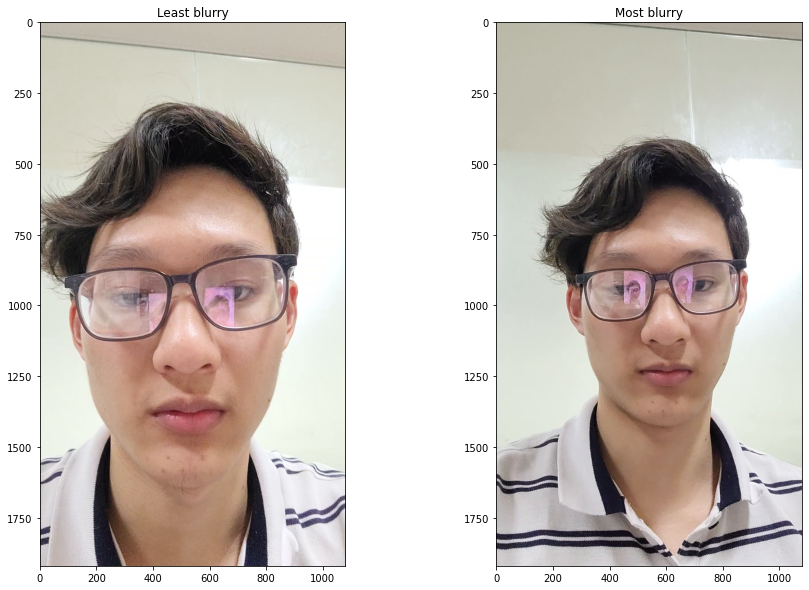

In [ ]:
# @title Filter blurry frames.
from matplotlib import pyplot as plt
import numpy as np
import cv2

def variance_of_laplacian(image: np.ndarray) -> np.ndarray:
  """Compute the variance of the Laplacian which measure the focus."""
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return cv2.Laplacian(gray, cv2.CV_64F).var()


blur_filter_perc = 95.0 # @param {type: 'number'}
if blur_filter_perc > 0.0:
  image_paths = sorted(rgb_dir.iterdir())
  print('Loading images.')
  images = list(map(scene_manager.load_image, scene_manager.image_ids))
  print('Computing blur scores.')
  blur_scores = np.array([variance_of_laplacian(im) for im in images])
  blur_thres = np.percentile(blur_scores, blur_filter_perc)
  blur_filter_inds = np.where(blur_scores >= blur_thres)[0]
  blur_filter_scores = [blur_scores[i] for i in blur_filter_inds]
  blur_filter_inds = blur_filter_inds[np.argsort(blur_filter_scores)]
  blur_filter_scores = np.sort(blur_filter_scores)
  blur_filter_image_ids = [scene_manager.image_ids[i] for i in blur_filter_inds]
  print(f'Filtering {len(blur_filter_image_ids)} IDs: {blur_filter_image_ids}')
  num_filtered = scene_manager.filter_images(blur_filter_image_ids)
  print(f'Filtered {num_filtered} images')

  plt.figure(figsize=(15, 10))
  plt.subplot(121)
  plt.title('Least blurry')
  plt.imshow(images[blur_filter_inds[-1]])
  plt.subplot(122)
  plt.title('Most blurry')
  plt.imshow(images[blur_filter_inds[0]])

### Face Processing.

This section runs the optional step of computing facial landmarks for the purpose of test camera generation.

In [ ]:
import jax
from jax import numpy as jnp
from tensorflow_graphics.geometry.representation.ray import triangulate as ray_triangulate

use_face = True  # @param {type: 'boolean'}

<ipython-input-17-f290ee107e1e>:143: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



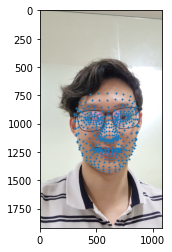

In [ ]:
# @title Compute 2D landmarks.

import imageio
import mediapipe as mp
from PIL import Image

if use_face:
  mp_face_mesh = mp.solutions.face_mesh
  mp_drawing = mp.solutions.drawing_utils 
  drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
  
  # Initialize MediaPipe Face Mesh.
  face_mesh = mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=2,
      min_detection_confidence=0.5)
  
  
  def compute_landmarks(image):
    height, width = image.shape[:2]
    results = face_mesh.process(image)
    if results.multi_face_landmarks is None:
      return None
    # Choose first face found.
    landmarks = results.multi_face_landmarks[0].landmark
    landmarks = np.array(
        [(o.x * width, o.y * height) for o in landmarks],
        dtype=np.uint32)
    return landmarks

  landmarks_dict = {}
  for item_id in scene_manager.image_ids:
    image = scene_manager.load_image(item_id)
    landmarks = compute_landmarks(image)
    if landmarks is not None:
      landmarks_dict[item_id] = landmarks
  
  landmark_item_ids = sorted(landmarks_dict)
  landmarks_pixels = np.array([landmarks_dict[i] for i in landmark_item_ids])
  landmarks_cameras = [scene_manager.camera_dict[i] for i in landmark_item_ids]
  
  from matplotlib import pyplot as plt
  plt.imshow(image)
  plt.scatter(x=landmarks[..., 0], y=landmarks[..., 1], s=1);

In [ ]:
# @title Triangulate landmarks in 3D.

if use_face:
  def compute_camera_rays(points, camera):
    origins = np.broadcast_to(camera.position[None, :], (points.shape[0], 3))
    directions = camera.pixels_to_rays(points.astype(jnp.float32))
    endpoints = origins + directions
    return origins, endpoints
  
  
  def triangulate_landmarks(landmarks, cameras):
    all_origins = []
    all_endpoints = []
    nan_inds = []
    for i, (camera_landmarks, camera) in enumerate(zip(landmarks, cameras)):
      origins, endpoints = compute_camera_rays(camera_landmarks, camera)
      if np.isnan(origins).sum() > 0.0 or np.isnan(endpoints).sum() > 0.0:
        continue
      all_origins.append(origins)
      all_endpoints.append(endpoints)
    all_origins = np.stack(all_origins, axis=-2).astype(np.float32)
    all_endpoints = np.stack(all_endpoints, axis=-2).astype(np.float32)
    weights = np.ones(all_origins.shape[:2], dtype=np.float32)
    points = np.array(ray_triangulate(all_origins, all_endpoints, weights))
  
    return points
  

  landmark_points = triangulate_landmarks(landmarks_pixels, landmarks_cameras)
else:
  landmark_points = None

/usr/local/lib/python3.9/dist-packages/nerfies/camera.py:92: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.9/dist-packages/nerfies/camera.py:93: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.9/dist-packages/nerfies/camera.py:93: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.9/dist-packages/nerfies/camera.py:94: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.9/dist-packages/nerfies/camera.py:94: RuntimeWarning:

invalid value encountered in subtract



In [ ]:
# @title Normalize scene based on landmarks.
from scipy import linalg

DEFAULT_IPD = 0.06
NOSE_TIP_IDX = 1
FOREHEAD_IDX = 10
CHIN_IDX = 152
RIGHT_EYE_IDX = 145
LEFT_EYE_IDX = 385
RIGHT_TEMPLE_IDX = 162
LEFT_TEMPLE_IDX = 389


def _normalize(x):
  return x / linalg.norm(x)


def fit_plane_normal(points):
  """Fit a plane to the points and return the normal."""
  centroid = points.sum(axis=0) / points.shape[0]
  _, _, vh = linalg.svd(points - centroid)
  return vh[2, :]


def metric_scale_from_ipd(landmark_points, reference_ipd):
  """Infer the scene-to-metric conversion ratio from facial landmarks."""
  left_eye = landmark_points[LEFT_EYE_IDX]
  right_eye = landmark_points[RIGHT_EYE_IDX]
  model_ipd = linalg.norm(left_eye - right_eye)
  return reference_ipd / model_ipd


def basis_from_landmarks(landmark_points):
  """Computes an orthonormal basis from facial landmarks."""
  # Estimate Z by fitting a plane
  # This works better than trusting the chin to forehead vector, especially in
  # full body captures.
  face_axis_z = _normalize(fit_plane_normal(landmark_points))
  face_axis_y = _normalize(landmark_points[FOREHEAD_IDX] -
                           landmark_points[CHIN_IDX])
  face_axis_x = _normalize(landmark_points[LEFT_TEMPLE_IDX] -
                           landmark_points[RIGHT_TEMPLE_IDX])

  # Fitted plane normal might be flipped. Check using a heuristic and flip it if
  # it's flipped.
  z_flipped = np.dot(np.cross(face_axis_x, face_axis_y), face_axis_z)
  if z_flipped < 0.0:
    face_axis_z *= -1

  # Ensure axes are orthogonal, with the Z axis being fixed.
  face_axis_y = np.cross(face_axis_z, face_axis_x)
  face_axis_x = np.cross(face_axis_y, face_axis_z)

  return np.stack([face_axis_x, face_axis_y, face_axis_z]).T


if use_face:
  face_basis = basis_from_landmarks(landmark_points)
  new_scene_manager = scene_manager.change_basis(
      face_basis, landmark_points[NOSE_TIP_IDX])
  new_cameras = [new_scene_manager.camera_dict[i] for i in landmark_item_ids]
  new_landmark_points = triangulate_landmarks(landmarks_pixels, new_cameras)
  face_basis = basis_from_landmarks(landmark_points)
  scene_to_metric = metric_scale_from_ipd(landmark_points, DEFAULT_IPD)
  
  print(f'Computed basis: {face_basis}')
  print(f'Estimated metric scale = {scene_to_metric:.02f}')
else:
  new_scene_manager = scene_manager

Computed basis: [[ 0.99567556 -0.07417519  0.05558193]
 [-0.05389619 -0.95116514 -0.30388275]
 [ 0.07540816  0.29957297 -0.9510867 ]]
Estimated metric scale = 0.02


## Compute scene information.

This section computes the scene information necessary for NeRF training.

In [ ]:
# @title Compute near/far planes.
import pandas as pd


def estimate_near_far_for_image(scene_manager, image_id):
  """Estimate near/far plane for a single image based via point cloud."""
  points = filter_outlier_points(scene_manager.points, 0.95)
  points = np.concatenate([
      points,
      scene_manager.camera_positions,
  ], axis=0)
  camera = scene_manager.camera_dict[image_id]
  pixels = camera.project(points)
  depths = camera.points_to_local_points(points)[..., 2]

  # in_frustum = camera.ArePixelsInFrustum(pixels)
  in_frustum = (
      (pixels[..., 0] >= 0.0)
      & (pixels[..., 0] <= camera.image_size_x)
      & (pixels[..., 1] >= 0.0)
      & (pixels[..., 1] <= camera.image_size_y))
  depths = depths[in_frustum]

  in_front_of_camera = depths > 0
  depths = depths[in_front_of_camera]

  near = np.quantile(depths, 0.001)
  far = np.quantile(depths, 0.999)

  return near, far


def estimate_near_far(scene_manager):
  """Estimate near/far plane for a set of randomly-chosen images."""
  # image_ids = sorted(scene_manager.images.keys())
  image_ids = scene_manager.image_ids
  rng = np.random.RandomState(0)
  image_ids = rng.choice(
      image_ids, size=len(scene_manager.camera_list), replace=False)
  
  result = []
  for image_id in image_ids:
    near, far = estimate_near_far_for_image(scene_manager, image_id)
    result.append({'image_id': image_id, 'near': near, 'far': far})
  result = pd.DataFrame.from_records(result)
  return result


near_far = estimate_near_far(new_scene_manager)
print('Statistics for near/far computation:')
print(near_far.describe())
print()

near = near_far['near'].quantile(0.001) / 0.8
far = near_far['far'].quantile(0.999) * 1.2
print('Selected near/far values:')
print(f'Near = {near:.04f}')
print(f'Far = {far:.04f}')

Statistics for near/far computation:
            near        far
count  87.000000  87.000000
mean    5.567130  23.792429
std     5.217910   1.552871
min     0.156231  20.718063
25%     1.277715  22.976014
50%     2.164147  23.896808
75%    11.720444  24.916646
max    13.482452  26.819778

Selected near/far values:
Near = 0.2144
Far = 32.1333


/usr/local/lib/python3.9/dist-packages/nerfies/camera.py:291: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/dist-packages/nerfies/camera.py:292: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
# @title Compute scene center and scale.

def get_bbox_corners(points):
  lower = points.min(axis=0)
  upper = points.max(axis=0)
  return np.stack([lower, upper])


points = filter_outlier_points(new_scene_manager.points, 0.95)
bbox_corners = get_bbox_corners(
    np.concatenate([points, new_scene_manager.camera_positions], axis=0))

scene_center = np.mean(bbox_corners, axis=0)
scene_scale = 1.0 / np.sqrt(np.sum((bbox_corners[1] - bbox_corners[0]) ** 2))

print(f'Scene Center: {scene_center}')
print(f'Scene Scale: {scene_scale}')


Scene Center: [-0.24075523  0.174202    3.01793758]
Scene Scale: 0.028193633933804706


In [ ]:
# @title Visualize scene.

def scatter_points(points, size=2):
  return go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=size),
  )

camera = new_scene_manager.camera_list[0]
near_points = camera.pixels_to_points(
    camera.get_pixel_centers()[::8, ::8], jnp.array(near)).reshape((-1, 3))
far_points = camera.pixels_to_points(
    camera.get_pixel_centers()[::8, ::8], jnp.array(far)).reshape((-1, 3))

data = [
  scatter_points(new_scene_manager.points),
  scatter_points(new_scene_manager.camera_positions),
  scatter_points(bbox_corners),
  scatter_points(near_points),
  scatter_points(far_points),
]
if use_face:
  data.append(scatter_points(new_landmark_points))
fig = go.Figure(data=data)
fig.update_layout(scene_dragmode='orbit')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Generate test cameras.

In [ ]:
# @title Define Utilities.
_EPSILON = 1e-5


def points_bound(points):
  """Computes the min and max dims of the points."""
  min_dim = np.min(points, axis=0)
  max_dim = np.max(points, axis=0)
  return np.stack((min_dim, max_dim), axis=1)


def points_centroid(points):
  """Computes the centroid of the points from the bounding box."""
  return points_bound(points).mean(axis=1)


def points_bounding_size(points):
  """Computes the bounding size of the points from the bounding box."""
  bounds = points_bound(points)
  return np.linalg.norm(bounds[:, 1] - bounds[:, 0])


def look_at(camera,
            camera_position: np.ndarray,
            look_at_position: np.ndarray,
            up_vector: np.ndarray):
  look_at_camera = camera.copy()
  optical_axis = look_at_position - camera_position
  norm = np.linalg.norm(optical_axis)
  if norm < _EPSILON:
    raise ValueError('The camera center and look at position are too close.')
  optical_axis /= norm

  right_vector = np.cross(optical_axis, up_vector)
  norm = np.linalg.norm(right_vector)
  if norm < _EPSILON:
    raise ValueError('The up-vector is parallel to the optical axis.')
  right_vector /= norm

  # The three directions here are orthogonal to each other and form a right
  # handed coordinate system.
  camera_rotation = np.identity(3)
  camera_rotation[0, :] = right_vector
  camera_rotation[1, :] = np.cross(optical_axis, right_vector)
  camera_rotation[2, :] = optical_axis

  look_at_camera.position = camera_position
  look_at_camera.orientation = camera_rotation
  return look_at_camera


In [ ]:
# @title Generate camera trajectory.

import math
from scipy import interpolate
from plotly.offline import iplot
import plotly.graph_objs as go


def compute_camera_rays(points, camera):
  origins = np.broadcast_to(camera.position[None, :], (points.shape[0], 3))
  directions = camera.pixels_to_rays(points.astype(jnp.float32))
  endpoints = origins + directions
  return origins, endpoints


def triangulate_rays(origins, directions):
  origins = origins[np.newaxis, ...].astype('float32')
  directions = directions[np.newaxis, ...].astype('float32')
  weights = np.ones(origins.shape[:2], dtype=np.float32)
  points = np.array(ray_triangulate(origins, origins + directions, weights))
  return points.squeeze()


ref_cameras = [c for c in new_scene_manager.camera_list]
origins = np.array([c.position for c in ref_cameras])
directions = np.array([c.optical_axis for c in ref_cameras])
look_at = triangulate_rays(origins, directions)
print('look_at', look_at)

avg_position = np.mean(origins, axis=0)
print('avg_position', avg_position)

up = -np.mean([c.orientation[..., 1] for c in ref_cameras], axis=0)
print('up', up)

bounding_size = points_bounding_size(origins) / 2
x_scale =   0.75# @param {type: 'number'}
y_scale = 0.75  # @param {type: 'number'}
xs = x_scale * bounding_size
ys = y_scale * bounding_size
radius = 0.75  # @param {type: 'number'}
num_frames = 100  # @param {type: 'number'}


origin = np.zeros(3)

ref_camera = ref_cameras[0]
print(ref_camera.position)
z_offset = -0.1

angles = np.linspace(0, 2*math.pi, num=num_frames)
positions = []
for angle in angles:
  x = np.cos(angle) * radius * xs
  y = np.sin(angle) * radius * ys
  # x = xs * radius * np.cos(angle) / (1 + np.sin(angle) ** 2)
  # y = ys * radius * np.sin(angle) * np.cos(angle) / (1 + np.sin(angle) ** 2)

  position = np.array([x, y, z_offset])
  # Make distance to reference point constant.
  position = avg_position + position
  positions.append(position)

positions = np.stack(positions)

orbit_cameras = []
for position in positions:
  camera = ref_camera.look_at(position, look_at, up)
  orbit_cameras.append(camera)

camera_paths = {'orbit-mild': orbit_cameras}

traces = [
  scatter_points(new_scene_manager.points),
  scatter_points(new_scene_manager.camera_positions),
  scatter_points(bbox_corners),
  scatter_points(near_points),
  scatter_points(far_points),

  scatter_points(positions),
  scatter_points(origins),
]
fig = go.Figure(traces)
fig.update_layout(scene_dragmode='orbit')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Save data.

In [ ]:
# @title Save scene information to `scene.json`.
from pprint import pprint
import json

scene_json_path = root_dir /  'scene.json'
with scene_json_path.open('w') as f:
  json.dump({
      'scale': scene_scale,
      'center': scene_center.tolist(),
      'bbox': bbox_corners.tolist(),
      'near': near * scene_scale,
      'far': far * scene_scale,
  }, f, indent=2)

print(f'Saved scene information to {scene_json_path}')

Saved scene information to /content/gdrive/MyDrive/nerfies_1/captures/capture1/scene.json


In [ ]:
# @title Save dataset split to `dataset.json`.

all_ids = scene_manager.image_ids
val_ids = all_ids[::20]
train_ids = sorted(set(all_ids) - set(val_ids))
dataset_json = {
    'count': len(scene_manager),
    'num_exemplars': len(train_ids),
    'ids': scene_manager.image_ids,
    'train_ids': train_ids,
    'val_ids': val_ids,
}

dataset_json_path = root_dir / 'dataset.json'
with dataset_json_path.open('w') as f:
    json.dump(dataset_json, f, indent=2)

print(f'Saved dataset information to {dataset_json_path}')

Saved dataset information to /content/gdrive/MyDrive/nerfies_1/captures/capture1/dataset.json


In [ ]:
# @title Save metadata information to `metadata.json`.
import bisect

metadata_json = {}
for i, image_id in enumerate(train_ids):
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }
for i, image_id in enumerate(val_ids):
  i = bisect.bisect_left(train_ids, image_id)
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }

metadata_json_path = root_dir / 'metadata.json'
with metadata_json_path.open('w') as f:
    json.dump(metadata_json, f, indent=2)

print(f'Saved metadata information to {metadata_json_path}')

Saved metadata information to /content/gdrive/MyDrive/nerfies_1/captures/capture1/metadata.json


In [ ]:
# @title Save cameras.
camera_dir = root_dir / 'camera'
camera_dir.mkdir(exist_ok=True, parents=True)
for item_id, camera in new_scene_manager.camera_dict.items():
  camera_path = camera_dir / f'{item_id}.json'
  print(f'Saving camera to {camera_path!s}')
  with camera_path.open('w') as f:
    json.dump(camera.to_json(), f, indent=2)

Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000004.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000005.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000006.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000007.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000008.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000009.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000010.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000011.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000012.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000013.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera/000014.json
Saving camera to /content/gdrive

In [ ]:
# @title Save test cameras.

import json

test_camera_dir = root_dir / 'camera-paths'
for test_path_name, test_cameras in camera_paths.items():
  out_dir = test_camera_dir / test_path_name
  out_dir.mkdir(exist_ok=True, parents=True)
  for i, camera in enumerate(test_cameras):
    camera_path = out_dir / f'{i:06d}.json'
    print(f'Saving camera to {camera_path!s}')
    with camera_path.open('w') as f:
      json.dump(camera.to_json(), f, indent=2)

Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000000.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000001.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000002.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000003.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000004.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000005.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000006.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000007.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild/000008.json
Saving camera to /content/gdrive/MyDrive/nerfies_1/capt

## Training

 * You are now ready to train a Nerfie!
 * Head over to the [training Colab](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb) for a basic demo.